# 고혈압 분석 모델

고혈압 판단 조건
1. 'AS1_BPLIE2S_A' 누운 자세 - 2회 sys 측정 평균 140 이상
2. 'AS1_BPLIE2D_A',누운 자세 - 2회 dia 측정 평균 90 이상
3. 'AS1_DrugHtCu' 2번 응답

## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - y: 종속변수
    - 'AS1_BPLIE2S_A'
    - 'AS1_BPLIE2D_A'
    - 'AS1_DrugHtCu'
    - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

- 15차
  - 2021-09-26
  - 누락 되었던 식품군 F1 ~ F17 데이터 추가
  - 모델 제작에는 사용하지 않음

- 16차
  - 2021-10-01
  - JOBB 추가
  - 키 대신에 BMI 넣음
  - FA를 DP로 변경

- 17차
  - 2022-05-04
  - _1000 변수만으로 모델 학습

- 18차
  - 2022-05-13
  - 혈압을 예측하는 회귀모델 구현
  - _1000 변수 + 원래 쓰던거
  - 77777 to 0
    - AS1_DRDUA: 77777 to 0
    - AS1_HVSMAM: 77777 to 0

  - 그냥 삭제

- 19차
  - 2022-06-01
  - 데이터 describe
    - AS1_B01 있, 1000kcal 나눔
    - AS1_B01 있, 안 나눔
    - AS1_B01 없, 1000kcal 나눔
    - AS1_B01 없, 안 나눔
  
  - 유전적 요인 분석하기
    - 아빠: Father
    - 엄마: Mather
    - 형제자매: Sibling

- 20차
  - 2022-09-17
  - data sampling
  - fn 너무 높음...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## dataset 불러오기 and 분리
- train, test

In [19]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/Scaled_X_220709.csv', index_col=0)
# X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/X_220706.csv', index_col=0)
raw_y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/y_220706.csv', index_col=0)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Columns: 129 entries, AS1_SEX to AS1_FMLPREL1A_3.0
dtypes: float64(129)
memory usage: 8.1+ MB


In [20]:
# AS1_B01 없, 안 나눔
# X = X.drop(columns=['AS1_B01',
#                     'AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                     'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                     'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                     'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                     'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                     'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                     'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                     'AS1_B24_1000',
#                     ])

# # AS1_B01 없, 1000kcal 나눔
# X = X.drop(columns=['AS1_B01',
#                     'AS1_B02', 'AS1_B03', 'AS1_B04',
#                     'AS1_B05', 'AS1_B06', 'AS1_B07',
#                     'AS1_B08', 'AS1_B09', 'AS1_B10',
#                     'AS1_B11', 'AS1_B12', 'AS1_B13',
#                     'AS1_B14', 'AS1_B15', 'AS1_B16',
#                     'AS1_B17', 'AS1_B18', 'AS1_B19',
#                     'AS1_B20', 'AS1_B21', 'AS1_B23',
#                     'AS1_B24',
#                     ])

# # AS1_B01 있, 안 나눔
X = X.drop(columns=['AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
                    'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
                    'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
                    'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
                    'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
                    'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
                    'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
                    'AS1_B24_1000',
                    ])

# 영양소(nutrients) 변수 AS1_B01(에너지), 1000kcal 나눔 (보정)
# X = X.drop(columns=['AS1_B02', 'AS1_B03', 'AS1_B04',
#                     'AS1_B05', 'AS1_B06', 'AS1_B07',
#                     'AS1_B08', 'AS1_B09', 'AS1_B10',
#                     'AS1_B11', 'AS1_B12', 'AS1_B13',
#                     'AS1_B14', 'AS1_B15', 'AS1_B16',
#                     'AS1_B17', 'AS1_B18', 'AS1_B19',
#                     'AS1_B20', 'AS1_B21', 'AS1_B23',
#                     'AS1_B24',
#                     ])

X = X.drop(columns=['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
                    'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17'])

In [21]:
# y = raw_y['AS1_DRUGHTCU_FILLNA']
# y = raw_y['AS1_BPLIE2S_A']
# y = raw_y['AS1_BPLIE2D_A']
y = raw_y['HYPERTENSION']

## sampling

OverSampling, UnderSampling

참고자료: https://ek-koh.github.io/data%20analysis/imbalanced/

- 언더 샘플링(Undersampling
  - 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소시키는 기법
  - ROS 사용
    - 설명: https://imbalanced-learn.org/stable/under_sampling.html

- 오버 샘플링(Oversampling)
  - 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식하여 학습에 충분한 데이터를 확보하는 기법
  - 오버 샘플링 방식이 일반적으로 언더 샘플링보다 예측 성능이 더 유리함
  - SMOTE 사용
    - 설명: https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

### 테스트 결과

- UnderSampling
 -

- OverSampling
  - Training error: 0.316 
  - Accuracy: 0.684
  - sensitivity: 0.721 
  - specificity: 0.647

### 결론

1. 샘플링하지 않고 사용.
2. 편향된 데이터에 맞춘 딥러닝 모델 재설계

In [16]:
# 클래스 불균형 처리를 해주는 imbalanced-learn를 호출
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE

# ros, rus 객체
rus = RandomUnderSampler()  # under
nm1 = NearMiss(version=1)  # under
smote = SMOTE(random_state=415)  # over

In [23]:
# Under 샘플링
# undersampled_data, undersampled_label = rus.fit_resample(X, y)
# undersampled_data, undersampled_label = nm1.fit_resample(X, y)

# X = pd.DataFrame(undersampled_data, columns=X.columns)
# y = pd.Series(undersampled_label)

# # 전체 데이터 neg 1883 샘플링

# X = pd.concat([X[y == 1], X[y == 0].sample(n=1511, random_state=415)])
# y = pd.concat([y[y == 1], y[y == 0].sample(n=1511, random_state=415)])

X_os, y_os = smote.fit_resample(X, y) 

In [32]:
print("샘플링 전:", (y == 0).sum(), (y == 1).sum())
print("샘플링 후:", (y_os == 0).sum(), (y_os == 1).sum())

샘플링 전: 6266 1883
샘플링 후: 6266 6266


In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.2, random_state=415)
# X_train, X_test, y_train, y_test = train_test_split(X, raw_y, test_size=0.2, random_state=415)
# X_train = pd.concat([X_train[y_train == 1], X_train[y_train == 0].sample(n=1511, random_state=415)])
# y_train = pd.concat([y_train[y_train == 1], y_train[y_train == 0].sample(n=1511, random_state=415)])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10025, 90) (2507, 90) (10025,) (2507,)


In [36]:
print(f"""
전체 데이터 개수: {len(y)}
전체 데이터 pos: {(y == 1).sum()}
전체 데이터 neg: {(y == 0).sum()}

train 데이터 개수: {len(y_train)}
train 데이터 pos: {(y_train == 1).sum()}
train 데이터 neg: {(y_train == 0).sum()}

test 데이터 개수: {len(y_test)}
test 데이터 pos: {(y_test == 1).sum()}
test 데이터 neg: {(y_test == 0).sum()}
""")


전체 데이터 개수: 8149
전체 데이터 pos: 1883
전체 데이터 neg: 6266

train 데이터 개수: 10025
train 데이터 pos: 5013
train 데이터 neg: 5012

test 데이터 개수: 2507
test 데이터 pos: 1253
test 데이터 neg: 1254



## DNN

In [37]:
UNITS = 32
EPOCH = 128
DROPOUT = 0.05
LEARNINGRATE = 0.01

In [38]:
# class ClearTrainingOutput(keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [39]:
# nodes = [8, 16, 32, 40, 48, 56, 64]
# scoreList = []

NODE = 16

In [40]:
model = Sequential()
model.add(Dense(NODE, activation='relu'))  # input layer requires input_dim param

model.add(Dropout(DROPOUT))
model.add(Dense(NODE, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(NODE, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(NODE, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(NODE, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(NODE, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1

model.compile(loss="binary_crossentropy",
              optimizer = Adam(learning_rate = LEARNINGRATE),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=es)
scores = model.evaluate(X_test, y_test)

Epoch 30: early stopping
79/79 [==============================] - 0s 2ms/step - loss: 0.5789 - accuracy: 0.6837


## 민감도 특이도

2022-09-06 추가

In [41]:
from sklearn.metrics import confusion_matrix, f1_score

In [42]:
y_pred_r = model.predict(X_test)
y_pred_r = np.reshape(y_pred_r, len(y_pred_r))
y_pred = np.where(y_pred_r <= 0.5, 0, 1)
(y_pred == 1).sum()

1346

In [43]:
cm = confusion_matrix(y_test, y_pred)
scores = {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
print(scores)
# print((scores['tp'] + scores['tn']) / (scores['tn'] + scores['fp'] + scores['fn'] + scores['tp']))

{'tn': 811, 'fp': 443, 'fn': 350, 'tp': 903}


In [45]:
print("Training error:", ((scores['fp'] + scores['fn']) / (scores['tn'] + scores['fp'] + scores['fn'] + scores['tp'])).round(3),
      "\nAccuracy:", ((scores['tp'] + scores['tn']) / (scores['tn'] + scores['fp'] + scores['fn'] + scores['tp'])).round(3),)
print('sensitivity:', (scores['tp'] / (scores['tp'] + scores['fn'])).round(3), # recall
      '\nspecificity:', (scores['tn'] / (scores['fp'] + scores['tn'])).round(3)) 

Training error: 0.316 
Accuracy: 0.684
sensitivity: 0.721 
specificity: 0.647


In [ ]:
y_test

## feature importance


In [46]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [48]:
# Define hyperparameters
params_xgb = {"max_depth": 5,
              "eta": 0.1,
              'objective': 'binary:logistic',
              'eval_metric':'logloss',
              'early_stopping': 32
              }

num_round = 400

In [ ]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=num_round, evals=wlist)
xgb_model

In [50]:
y_pred_r = xgb_model.predict(dtest)
y_pred_r = np.reshape(y_pred_r, len(y_pred_r))
y_pred = np.where((y_pred_r < 0.5), 0, 1)
(y_pred == 1).sum()

1095

In [51]:
cm = confusion_matrix(y_test, y_pred)
scores = {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
print(scores)
print("Training error:", ((scores['fp'] + scores['fn']) / (scores['tn'] + scores['fp'] + scores['fn'] + scores['tp'])).round(3),
      "\nACC:",((scores['tp'] + scores['tn']) / (scores['tn'] + scores['fp'] + scores['fn'] + scores['tp'])).round(3) )
print('sensitivity:', (scores['tp'] / (scores['tp'] + scores['fn'])).round(3), # recall
      '\nspecificity:', (scores['tn'] / (scores['fp'] + scores['tn'])).round(3)) 

{'tn': 1152, 'fp': 102, 'fn': 260, 'tp': 993}
Training error: 0.144 
ACC: 0.856
sensitivity: 0.792 
specificity: 0.919


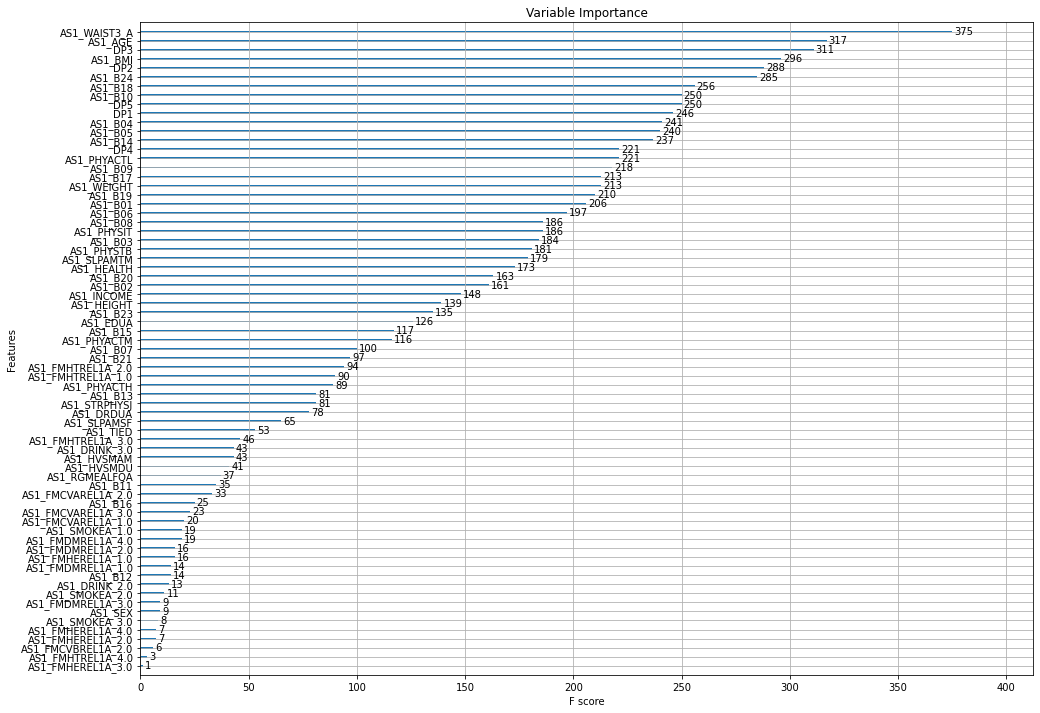

In [52]:
fig, ax = plt.subplots(figsize=(16, 12))
plot_importance(xgb_model, title="Variable Importance", ax=ax)

In [ ]:
tp, tn, fp, fn = 73, 1168, 90, 299
print("Training error:", round(((fp + fn) / (tn + fp + fn + tp)) * 100, 3),
      "\nACC:",round((tp + tn) / (tn + fp + fn + tp) * 100, 3))

Training error: 23.865 
ACC: 76.135
